# WEDS Aging index

# Notebook description
In this notebook we build Aging index on WEDS data

# Input data
1) WEDS_DATA_EXTRACT_SOFT_STICTION_3.2_2023_11_06_ADDITIONAL_METRICS_20231108.csv

# TODO: Only use PET_ID for train test split

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pylab import plt
import os, itertools, sys, pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix,\
                            accuracy_score,precision_score,recall_score,roc_auc_score
from catboost import CatBoostClassifier, Pool, cv
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from xgboost import XGBClassifier, plot_tree
from typing import TypeVar, Tuple
from sklearn.base import BaseEstimator
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
palette = sns.color_palette('deep', 10)
plt.style.use('seaborn-whitegrid')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
rndm_state=21
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
import sys,os
scripts_master = os.path.dirname('../../advanced_stats_code_library/src/')
sys.path.insert(0, scripts_master) 
from patient_index.patient_index import PatientIndex

# Read data

In [3]:
weds_df = pd.read_csv("gs://hpn_cte_advanced_stats_data_repository/yahui_data_repository/WEDS_DATA_EXTRACT_SOFT_STICTION_3.2_2023_11_06_ADDITIONAL_METRICS_20231108.csv")

/opt/conda/envs/hillsadvancedml_envi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (11,313,641,642,643,644,645,646,647,648,653,655,657,658,659,671) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
weds_df.head()

,Unnamed: 0,PET_ID,DEVICE_ID,STUDY_ID,STUDY_NAME,PET_NAME,DATE,NORMALIZED_STUDY_DAY,NORMALIZED_QUALIFYING_STUDY_DAY,STUDY_DAY_COUNTER,STUDY_GROUP,BASELINE_START,START_DATE,ENROLLMENT_DATE,COMPLETION_DATE,END_DATE,EXCESSIVE_RUNNING,TIMEZONE,QUALIFYING_DATA_DAY,IS_QUALIFIED,DAILYDATAQUALITYINDREASON,VAR_TD_1_Q1_2,VAR_CE_1_Q1_2,VAR_MIN_1_Q1_2,VAR_MED_1_Q1_2,VAR_RANG_1_Q1_2,VAR_MAX_1_Q1_2,VAR_AVG_1_Q1_2,VAR_SD_1_Q1_2,VAR_IQR_1_Q1_2,VAR_ACE_1_Q1_2,VAR_SDCE_1_Q1_2,VAR_IQRCE_1_Q1_2,VAR_CE3SD_1_Q1_2,VAR_TD_3_Q1_2,VAR_CE_3_Q1_2,VAR_MIN_3_Q1_2,VAR_MED_3_Q1_2,VAR_RANG_3_Q1_2,VAR_MAX_3_Q1_2,VAR_AVG_3_Q1_2,VAR_SD_3_Q1_2,VAR_IQR_3_Q1_2,VAR_ACE_3_Q1_2,VAR_SDCE_3_Q1_2,VAR_IQRCE_3_Q1_2,VAR_CE3SD_3_Q1_2,VAR_TD_5_Q1_2,VAR_CE_5_Q1_2,VAR_MIN_5_Q1_2,VAR_MED_5_Q1_2,VAR_RANG_5_Q1_2,VAR_MAX_5_Q1_2,VAR_AVG_5_Q1_2,VAR_SD_5_Q1_2,VAR_IQR_5_Q1_2,VAR_ACE_5_Q1_2,VAR_SDCE_5_Q1_2,VAR_IQRCE_5_Q1_2,VAR_CE3SD_5_Q1_2,VAR_TD_4_Q1_2,VAR_CE_4_Q1_2,VAR_MIN_4_Q1_2,VAR_MED_4_Q1_2,VAR_RANG_4_Q1_2,VAR_MAX_4_Q1_2,VAR_AVG_4_Q1_2,VAR_SD_4_Q1_2,VAR_IQR_4_Q1_2,VAR_ACE_4_Q1_2,VAR_SDCE_4_Q1_2,VAR_IQRCE_4_Q1_2,VAR_CE3SD_4_Q1_2,VAR_TD_12_Q1_2,VAR_CE_12_Q1_2,VAR_MIN_12_Q1_2,VAR_MED_12_Q1_2,VAR_RANG_12_Q1_2,VAR_MAX_12_Q1_2,VAR_AVG_12_Q1_2,VAR_SD_12_Q1_2,VAR_IQR_12_Q1_2,VAR_ACE_12_Q1_2,VAR_SDCE_12_Q1_2,VAR_IQRCE_12_Q1_2,VAR_CE3SD_12_Q1_2,VAR_TD_2_Q1_2,VAR_CE_2_Q1_2,VAR_MIN_2_Q1_2,VAR_MED_2_Q1_2,VAR_RANG_2_Q1_2,VAR_MAX_2_Q1_2,VAR_AVG_2_Q1_2,VAR_SD_2_Q1_2,VAR_IQR_2_Q1_2,VAR_ACE_2_Q1_2,VAR_SDCE_2_Q1_2,VAR_IQRCE_2_Q1_2,VAR_CE3SD_2_Q1_2,VAR_TD_46_Q1_2,VAR_CE_46_Q1_2,VAR_MIN_46_Q1_2,VAR_MED_46_Q1_2,VAR_RANG_46_Q1_2,VAR_MAX_46_Q1_2,VAR_AVG_46_Q1_2,VAR_SD_46_Q1_2,VAR_IQR_46_Q1_2,VAR_ACE_46_Q1_2,VAR_SDCE_46_Q1_2,VAR_IQRCE_46_Q1_2,VAR_CE3SD_46_Q1_2,VAR_TD_45_Q1_2,VAR_CE_45_Q1_2,VAR_MIN_45_Q1_2,VAR_MED_45_Q1_2,VAR_RANG_45_Q1_2,VAR_MAX_45_Q1_2,VAR_AVG_45_Q1_2,VAR_SD_45_Q1_2,VAR_IQR_45_Q1_2,VAR_ACE_45_Q1_2,VAR_SDCE_45_Q1_2,VAR_IQRCE_45_Q1_2,VAR_IDX_11_Q1_2,VAR_CE3SD_45_Q1_2,VAR_TD_1_Q2_2,VAR_CE_1_Q2_2,VAR_MIN_1_Q2_2,VAR_MED_1_Q2_2,VAR_RANG_1_Q2_2,VAR_MAX_1_Q2_2,VAR_AVG_1_Q2_2,VAR_SD_1_Q2_2,VAR_IQR_1_Q2_2,VAR_ACE_1_Q2_2,VAR_SDCE_1_Q2_2,VAR_IQRCE_1_Q2_2,VAR_CE3SD_1_Q2_2,VAR_TD_3_Q2_2,VAR_CE_3_Q2_2,VAR_MIN_3_Q2_2,VAR_MED_3_Q2_2,VAR_RANG_3_Q2_2,VAR_MAX_3_Q2_2,VAR_AVG_3_Q2_2,VAR_SD_3_Q2_2,VAR_IQR_3_Q2_2,VAR_ACE_3_Q2_2,VAR_SDCE_3_Q2_2,VAR_IQRCE_3_Q2_2,VAR_CE3SD_3_Q2_2,VAR_TD_5_Q2_2,VAR_CE_5_Q2_2,VAR_MIN_5_Q2_2,VAR_MED_5_Q2_2,VAR_RANG_5_Q2_2,VAR_MAX_5_Q2_2,VAR_AVG_5_Q2_2,VAR_SD_5_Q2_2,VAR_IQR_5_Q2_2,VAR_ACE_5_Q2_2,VAR_SDCE_5_Q2_2,VAR_IQRCE_5_Q2_2,VAR_CE3SD_5_Q2_2,VAR_TD_4_Q2_2,VAR_CE_4_Q2_2,VAR_MIN_4_Q2_2,VAR_MED_4_Q2_2,VAR_RANG_4_Q2_2,VAR_MAX_4_Q2_2,VAR_AVG_4_Q2_2,VAR_SD_4_Q2_2,VAR_IQR_4_Q2_2,VAR_ACE_4_Q2_2,VAR_SDCE_4_Q2_2,VAR_IQRCE_4_Q2_2,VAR_CE3SD_4_Q2_2,VAR_TD_12_Q2_2,VAR_CE_12_Q2_2,VAR_MIN_12_Q2_2,VAR_MED_12_Q2_2,VAR_RANG_12_Q2_2,VAR_MAX_12_Q2_2,VAR_AVG_12_Q2_2,VAR_SD_12_Q2_2,VAR_IQR_12_Q2_2,VAR_ACE_12_Q2_2,VAR_SDCE_12_Q2_2,VAR_IQRCE_12_Q2_2,VAR_CE3SD_12_Q2_2,VAR_TD_2_Q2_2,VAR_CE_2_Q2_2,VAR_MIN_2_Q2_2,VAR_MED_2_Q2_2,VAR_RANG_2_Q2_2,VAR_MAX_2_Q2_2,VAR_AVG_2_Q2_2,VAR_SD_2_Q2_2,VAR_IQR_2_Q2_2,VAR_ACE_2_Q2_2,VAR_SDCE_2_Q2_2,VAR_IQRCE_2_Q2_2,VAR_CE3SD_2_Q2_2,VAR_TD_46_Q2_2,VAR_CE_46_Q2_2,VAR_MIN_46_Q2_2,VAR_MED_46_Q2_2,VAR_RANG_46_Q2_2,VAR_MAX_46_Q2_2,VAR_AVG_46_Q2_2,VAR_SD_46_Q2_2,VAR_IQR_46_Q2_2,VAR_ACE_46_Q2_2,VAR_SDCE_46_Q2_2,VAR_IQRCE_46_Q2_2,VAR_CE3SD_46_Q2_2,VAR_TD_45_Q2_2,VAR_CE_45_Q2_2,VAR_MIN_45_Q2_2,VAR_MED_45_Q2_2,VAR_RANG_45_Q2_2,VAR_MAX_45_Q2_2,VAR_AVG_45_Q2_2,VAR_SD_45_Q2_2,VAR_IQR_45_Q2_2,VAR_ACE_45_Q2_2,VAR_SDCE_45_Q2_2,VAR_IQRCE_45_Q2_2,VAR_IDX_11_Q2_2,VAR_CE3SD_45_Q2_2,VAR_TD_1_Q3_2,VAR_CE_1_Q3_2,VAR_MIN_1_Q3_2,VAR_MED_1_Q3_2,VAR_RANG_1_Q3_2,VAR_MAX_1_Q3_2,VAR_AVG_1_Q3_2,VAR_SD_1_Q3_2,VAR_IQR_1_Q3_2,VAR_ACE_1_Q3_2,VAR_SDCE_1_Q3_2,VAR_IQRCE_1_Q3_2,VAR_CE3SD_1_Q3_2,VAR_TD_3_Q3_2,VAR_CE_3_Q3_2,VAR_MIN_3_Q3_2,VAR_MED_3_Q3_2,VAR_RANG_3_Q3_2,VAR_MAX_3_Q3_2,...,VAR_SDCE_45_Q4_2,VAR_IQRCE_45_Q4_2,VAR_IDX_11_Q4_2,VAR_CE3SD_45_Q4_2,VAR_TD_1_Q5_2,VAR_CE_1_Q5_2,VAR_MIN_1_Q5_2,VAR_MED_1_Q5_2,VAR_R

In [5]:
activity_columns = {
    'VAR_TD_1_Q5_2', #resting
    'VAR_TD_3_Q5_2', #running
    'VAR_TD_5_Q5_2', #scratching
    'VAR_TD_4_Q5_2', #shaking
    'VAR_TD_12_Q5_2', #sleeping
    'VAR_TD_2_Q5_2' #walking
}

In [6]:
# Get 99 percentile for each activity
percent_99_selected = weds_df[activity_columns].quantile(0.99)
rows_to_remove = weds_df[activity_columns].gt(percent_99_selected).any(axis=1)
# Remove patient days where any of the activity exceeds 99% for the overall population
weds = weds_df[~rows_to_remove]

# Sampling criteria

In [7]:
# Setting is_qualified to 
weds_qualified_df = weds[weds['IS_QUALIFIED']=='YES']

In [8]:
weds_qualified_df.head()

,Unnamed: 0,PET_ID,DEVICE_ID,STUDY_ID,STUDY_NAME,PET_NAME,DATE,NORMALIZED_STUDY_DAY,NORMALIZED_QUALIFYING_STUDY_DAY,STUDY_DAY_COUNTER,STUDY_GROUP,BASELINE_START,START_DATE,ENROLLMENT_DATE,COMPLETION_DATE,END_DATE,EXCESSIVE_RUNNING,TIMEZONE,QUALIFYING_DATA_DAY,IS_QUALIFIED,DAILYDATAQUALITYINDREASON,VAR_TD_1_Q1_2,VAR_CE_1_Q1_2,VAR_MIN_1_Q1_2,VAR_MED_1_Q1_2,VAR_RANG_1_Q1_2,VAR_MAX_1_Q1_2,VAR_AVG_1_Q1_2,VAR_SD_1_Q1_2,VAR_IQR_1_Q1_2,VAR_ACE_1_Q1_2,VAR_SDCE_1_Q1_2,VAR_IQRCE_1_Q1_2,VAR_CE3SD_1_Q1_2,VAR_TD_3_Q1_2,VAR_CE_3_Q1_2,VAR_MIN_3_Q1_2,VAR_MED_3_Q1_2,VAR_RANG_3_Q1_2,VAR_MAX_3_Q1_2,VAR_AVG_3_Q1_2,VAR_SD_3_Q1_2,VAR_IQR_3_Q1_2,VAR_ACE_3_Q1_2,VAR_SDCE_3_Q1_2,VAR_IQRCE_3_Q1_2,VAR_CE3SD_3_Q1_2,VAR_TD_5_Q1_2,VAR_CE_5_Q1_2,VAR_MIN_5_Q1_2,VAR_MED_5_Q1_2,VAR_RANG_5_Q1_2,VAR_MAX_5_Q1_2,VAR_AVG_5_Q1_2,VAR_SD_5_Q1_2,VAR_IQR_5_Q1_2,VAR_ACE_5_Q1_2,VAR_SDCE_5_Q1_2,VAR_IQRCE_5_Q1_2,VAR_CE3SD_5_Q1_2,VAR_TD_4_Q1_2,VAR_CE_4_Q1_2,VAR_MIN_4_Q1_2,VAR_MED_4_Q1_2,VAR_RANG_4_Q1_2,VAR_MAX_4_Q1_2,VAR_AVG_4_Q1_2,VAR_SD_4_Q1_2,VAR_IQR_4_Q1_2,VAR_ACE_4_Q1_2,VAR_SDCE_4_Q1_2,VAR_IQRCE_4_Q1_2,VAR_CE3SD_4_Q1_2,VAR_TD_12_Q1_2,VAR_CE_12_Q1_2,VAR_MIN_12_Q1_2,VAR_MED_12_Q1_2,VAR_RANG_12_Q1_2,VAR_MAX_12_Q1_2,VAR_AVG_12_Q1_2,VAR_SD_12_Q1_2,VAR_IQR_12_Q1_2,VAR_ACE_12_Q1_2,VAR_SDCE_12_Q1_2,VAR_IQRCE_12_Q1_2,VAR_CE3SD_12_Q1_2,VAR_TD_2_Q1_2,VAR_CE_2_Q1_2,VAR_MIN_2_Q1_2,VAR_MED_2_Q1_2,VAR_RANG_2_Q1_2,VAR_MAX_2_Q1_2,VAR_AVG_2_Q1_2,VAR_SD_2_Q1_2,VAR_IQR_2_Q1_2,VAR_ACE_2_Q1_2,VAR_SDCE_2_Q1_2,VAR_IQRCE_2_Q1_2,VAR_CE3SD_2_Q1_2,VAR_TD_46_Q1_2,VAR_CE_46_Q1_2,VAR_MIN_46_Q1_2,VAR_MED_46_Q1_2,VAR_RANG_46_Q1_2,VAR_MAX_46_Q1_2,VAR_AVG_46_Q1_2,VAR_SD_46_Q1_2,VAR_IQR_46_Q1_2,VAR_ACE_46_Q1_2,VAR_SDCE_46_Q1_2,VAR_IQRCE_46_Q1_2,VAR_CE3SD_46_Q1_2,VAR_TD_45_Q1_2,VAR_CE_45_Q1_2,VAR_MIN_45_Q1_2,VAR_MED_45_Q1_2,VAR_RANG_45_Q1_2,VAR_MAX_45_Q1_2,VAR_AVG_45_Q1_2,VAR_SD_45_Q1_2,VAR_IQR_45_Q1_2,VAR_ACE_45_Q1_2,VAR_SDCE_45_Q1_2,VAR_IQRCE_45_Q1_2,VAR_IDX_11_Q1_2,VAR_CE3SD_45_Q1_2,VAR_TD_1_Q2_2,VAR_CE_1_Q2_2,VAR_MIN_1_Q2_2,VAR_MED_1_Q2_2,VAR_RANG_1_Q2_2,VAR_MAX_1_Q2_2,VAR_AVG_1_Q2_2,VAR_SD_1_Q2_2,VAR_IQR_1_Q2_2,VAR_ACE_1_Q2_2,VAR_SDCE_1_Q2_2,VAR_IQRCE_1_Q2_2,VAR_CE3SD_1_Q2_2,VAR_TD_3_Q2_2,VAR_CE_3_Q2_2,VAR_MIN_3_Q2_2,VAR_MED_3_Q2_2,VAR_RANG_3_Q2_2,VAR_MAX_3_Q2_2,VAR_AVG_3_Q2_2,VAR_SD_3_Q2_2,VAR_IQR_3_Q2_2,VAR_ACE_3_Q2_2,VAR_SDCE_3_Q2_2,VAR_IQRCE_3_Q2_2,VAR_CE3SD_3_Q2_2,VAR_TD_5_Q2_2,VAR_CE_5_Q2_2,VAR_MIN_5_Q2_2,VAR_MED_5_Q2_2,VAR_RANG_5_Q2_2,VAR_MAX_5_Q2_2,VAR_AVG_5_Q2_2,VAR_SD_5_Q2_2,VAR_IQR_5_Q2_2,VAR_ACE_5_Q2_2,VAR_SDCE_5_Q2_2,VAR_IQRCE_5_Q2_2,VAR_CE3SD_5_Q2_2,VAR_TD_4_Q2_2,VAR_CE_4_Q2_2,VAR_MIN_4_Q2_2,VAR_MED_4_Q2_2,VAR_RANG_4_Q2_2,VAR_MAX_4_Q2_2,VAR_AVG_4_Q2_2,VAR_SD_4_Q2_2,VAR_IQR_4_Q2_2,VAR_ACE_4_Q2_2,VAR_SDCE_4_Q2_2,VAR_IQRCE_4_Q2_2,VAR_CE3SD_4_Q2_2,VAR_TD_12_Q2_2,VAR_CE_12_Q2_2,VAR_MIN_12_Q2_2,VAR_MED_12_Q2_2,VAR_RANG_12_Q2_2,VAR_MAX_12_Q2_2,VAR_AVG_12_Q2_2,VAR_SD_12_Q2_2,VAR_IQR_12_Q2_2,VAR_ACE_12_Q2_2,VAR_SDCE_12_Q2_2,VAR_IQRCE_12_Q2_2,VAR_CE3SD_12_Q2_2,VAR_TD_2_Q2_2,VAR_CE_2_Q2_2,VAR_MIN_2_Q2_2,VAR_MED_2_Q2_2,VAR_RANG_2_Q2_2,VAR_MAX_2_Q2_2,VAR_AVG_2_Q2_2,VAR_SD_2_Q2_2,VAR_IQR_2_Q2_2,VAR_ACE_2_Q2_2,VAR_SDCE_2_Q2_2,VAR_IQRCE_2_Q2_2,VAR_CE3SD_2_Q2_2,VAR_TD_46_Q2_2,VAR_CE_46_Q2_2,VAR_MIN_46_Q2_2,VAR_MED_46_Q2_2,VAR_RANG_46_Q2_2,VAR_MAX_46_Q2_2,VAR_AVG_46_Q2_2,VAR_SD_46_Q2_2,VAR_IQR_46_Q2_2,VAR_ACE_46_Q2_2,VAR_SDCE_46_Q2_2,VAR_IQRCE_46_Q2_2,VAR_CE3SD_46_Q2_2,VAR_TD_45_Q2_2,VAR_CE_45_Q2_2,VAR_MIN_45_Q2_2,VAR_MED_45_Q2_2,VAR_RANG_45_Q2_2,VAR_MAX_45_Q2_2,VAR_AVG_45_Q2_2,VAR_SD_45_Q2_2,VAR_IQR_45_Q2_2,VAR_ACE_45_Q2_2,VAR_SDCE_45_Q2_2,VAR_IQRCE_45_Q2_2,VAR_IDX_11_Q2_2,VAR_CE3SD_45_Q2_2,VAR_TD_1_Q3_2,VAR_CE_1_Q3_2,VAR_MIN_1_Q3_2,VAR_MED_1_Q3_2,VAR_RANG_1_Q3_2,VAR_MAX_1_Q3_2,VAR_AVG_1_Q3_2,VAR_SD_1_Q3_2,VAR_IQR_1_Q3_2,VAR_ACE_1_Q3_2,VAR_SDCE_1_Q3_2,VAR_IQRCE_1_Q3_2,VAR_CE3SD_1_Q3_2,VAR_TD_3_Q3_2,VAR_CE_3_Q3_2,VAR_MIN_3_Q3_2,VAR_MED_3_Q3_2,VAR_RANG_3_Q3_2,VAR_MAX_3_Q3_2,...,VAR_SDCE_45_Q4_2,VAR_IQRCE_45_Q4_2,VAR_IDX_11_Q4_2,VAR_CE3SD_45_Q4_2,VAR_TD_1_Q5_2,VAR_CE_1_Q5_2,VAR_MIN_1_Q5_2,VAR_MED_1_Q5_2,VAR_R

### Patients with less than 3 weeks of data

In [9]:
pet_id_unique_dates = weds_qualified_df.groupby(['PET_ID'])\
                    .agg({'DATE':'nunique'})

In [10]:
patient_with_less_than_3week = list(pet_id_unique_dates[pet_id_unique_dates['DATE']<21].index)

In [11]:
patient_with_less_than_3week 

[4233, 4252, 4284, 4286, 4479, 4502, 4508, 4521, 4587, 4819, 4874]

In [12]:
weds_final_filtered=weds_qualified_df[~weds_qualified_df['PET_ID']\
                                            .isin(patient_with_less_than_3week)]\
                                            .reset_index().drop(['index'],axis=1)

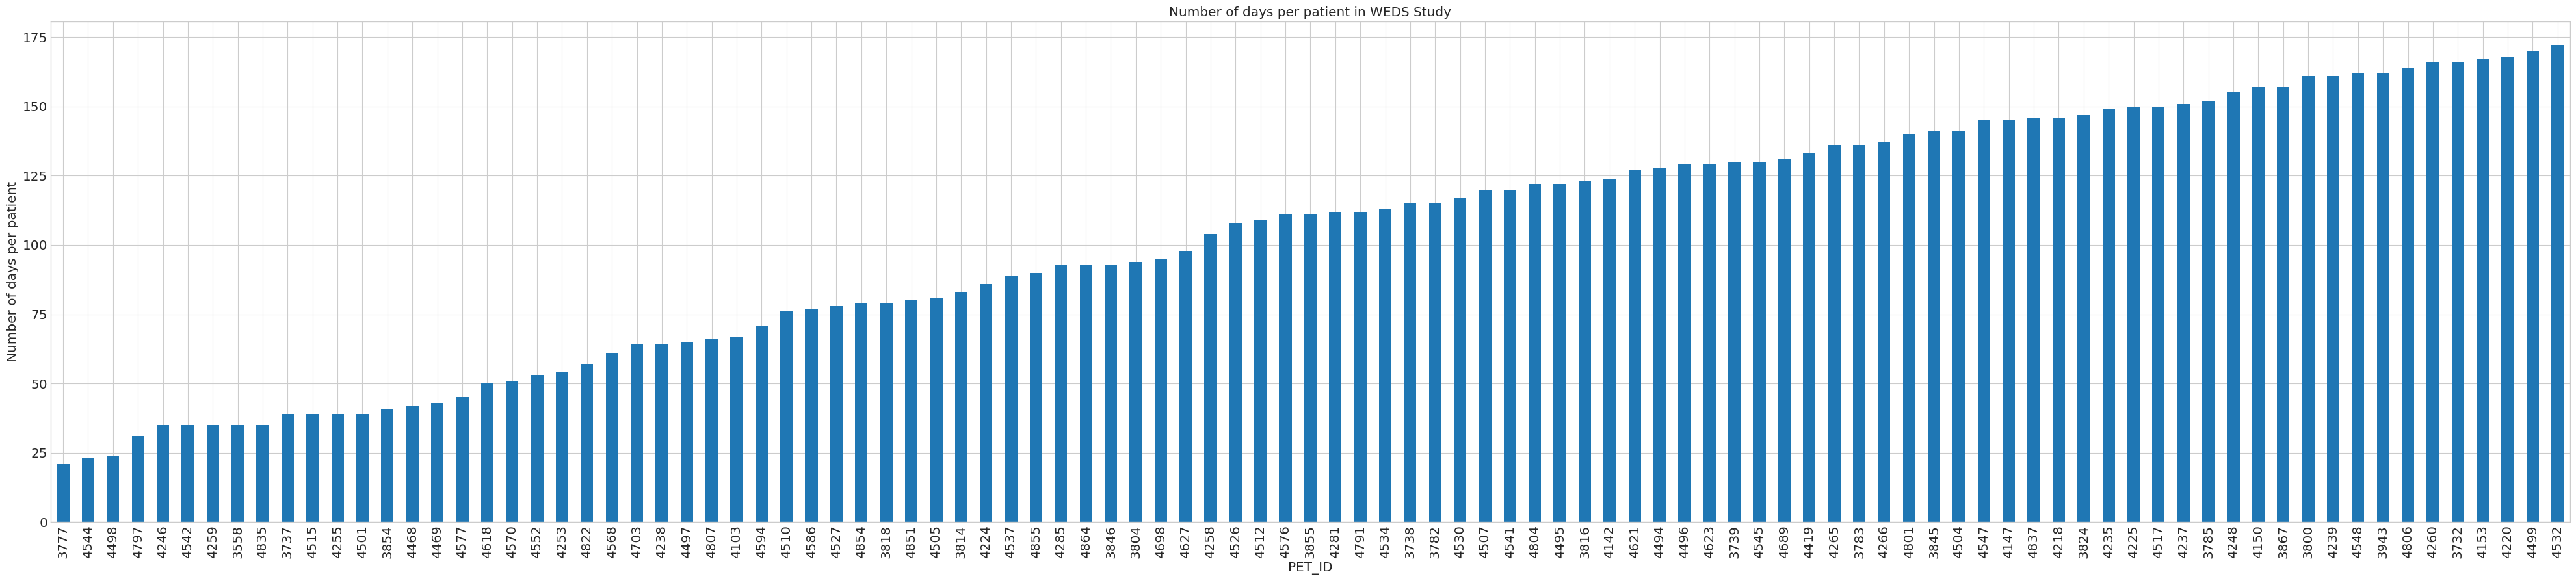

In [13]:
weds_final_filtered.groupby(['PET_ID'])\
                    .agg({'DATE':'nunique'})\
                    .sort_values(['DATE'])\
                    .plot(kind='bar',figsize=(50,10))
plt.title("Number of days per patient in WEDS Study")
plt.ylabel('Number of days per patient')
plt.legend('')

## Labelling dogs (AGING vs NON-Aging)

“””
Below is how to interpret this data:

Aging:  
1: All the Pets available under the ‘Aging Aging’ sheet  
2: All the Pets available under the ‘Aging Non-Aging’ sheet  
0: All other pets, which are not part of either of the above 2 sheets  
“””


In [14]:
weds_final_filtered['AGING'].value_counts()

2    5359
1    4472
0     552
Name: AGING, dtype: int64

In [15]:
aging_pet_ids = weds_final_filtered[weds_final_filtered['AGING']==1]['PET_ID'].unique()
non_aging_pet_ids = weds_final_filtered[weds_final_filtered['AGING']==2]['PET_ID'].unique()

In [16]:
aging_pet_ids

array([3854, 3867, 4698, 4468, 4469, 4220, 4235, 4237, 4494, 4239, 4495,
       4499, 3732, 4515, 4260, 4545, 4801, 4806, 3783, 4552, 3785, 4837,
       3558, 3816, 3824, 4618, 4627, 4147, 4689, 4703, 4238, 4512, 4265,
       4266, 4791, 4537, 4544, 4548, 4577, 3814])

In [17]:
non_aging_pet_ids

array([3845, 3855, 4150, 4153, 4419, 3943, 4225, 4496, 4497, 4246, 4248,
       4505, 4258, 4530, 4532, 4534, 4541, 4547, 4804, 3782, 4807, 3800,
       4570, 4576, 4854, 4855, 4851, 4542, 4864, 3846, 4621, 4623, 4142,
       4224, 4498, 4501, 4504, 3737, 3738, 3739, 4507, 4253, 4510, 4255,
       4259, 4526, 4527, 4285, 4797, 3777, 4822, 4568, 3804, 4835, 3818,
       4594])

In [18]:
# Assigning true label to dogs (Non-Aging:0 and Aging:1)
dog_and_true_label={**dict(zip(aging_pet_ids,np.ones(len(aging_pet_ids),dtype=int))),\
               **dict(zip(non_aging_pet_ids,np.zeros(len(non_aging_pet_ids),dtype=int)))}

weds_final_filtered['true_label']=weds_final_filtered['PET_ID'].map(dog_and_true_label).astype('Int64').values

#Dropping columns which are not useful for this model:
dataActivity=weds_final_filtered[weds_final_filtered['true_label'].notna()].copy()
#Converting the true_label to integer.
dataActivity = dataActivity.astype({'true_label':'int'})

In [19]:
dataActivity['true_label'].value_counts()

0    5359
1    4472
Name: true_label, dtype: int64

'Lab': 300 patients days are in Train
'Lab': 100 patient days are in Test

In [20]:
Counter(dog_and_true_label.values())

Counter({1: 40, 0: 56})

### Total number of healthy and mobility pets

In [21]:
len(aging_pet_ids)

40

In [22]:
len(non_aging_pet_ids)

56

In [23]:
pet_target_df = pd.DataFrame({"pet_id":dog_and_true_label.keys(),"target":dog_and_true_label.values()})
pet_target_df['target'].value_counts()

0    56
1    40
Name: target, dtype: int64

In [24]:
dataActivity['true_label'].value_counts()

0    5359
1    4472
Name: true_label, dtype: int64

In [25]:
activity_map = {
    'VAR_TD_1_Q5_2': 'Resting',
    'VAR_TD_3_Q5_2': 'Running',
    'VAR_TD_5_Q5_2': 'Scratching',
    'VAR_TD_4_Q5_2': 'Shaking',
    'VAR_TD_12_Q5_2': 'Sleep',
    'VAR_TD_2_Q5_2': 'Walking'
}

In [26]:
activity_map.keys()

dict_keys(['VAR_TD_1_Q5_2', 'VAR_TD_3_Q5_2', 'VAR_TD_5_Q5_2', 'VAR_TD_4_Q5_2', 'VAR_TD_12_Q5_2', 'VAR_TD_2_Q5_2'])

## Top 5 Features from freature selection

In [27]:
rndm_state=21

# train and test
X_train, X_test_outsample, y_train, y_test_outsample = train_test_split(pet_target_df['pet_id'].values, \
                                                                        pet_target_df['target'].values, \
                                 test_size=0.20, random_state=rndm_state, stratify=pet_target_df['target'])

outsample_df=pd.DataFrame({"pet_id":X_test_outsample,
                           "target":y_test_outsample})

features_list=['VAR_ACE_2_Q5_2','active_900','VAR_CE_1_Q4_2','VAR_ACE_3_Q4_2','VAR_TD_12_Q4_2']

aging_out_sample=list(outsample_df[outsample_df['target']==1]['pet_id'].unique())
non_aging_out_sample=list(outsample_df[outsample_df['target']==0]['pet_id'].unique())

params = {
        'depth':4,
        'loss_function':'Logloss',
        'verbose': False,
        'random_seed': rndm_state,
        'class_weights':[1,3.81]
}
mobility_index=PatientIndex(model_name='catboost',params=params)

X_train_set, y_train_set, X_test_outsample, y_test_outsample=mobility_index.split_by_animal(dataActivity,\
                                                                                        features_list,\
                                                                                        aging_out_sample,\
                                                                                        non_aging_out_sample,\
                                                                                        'PET_ID','DATE',\
                                                                                        'true_label')

X_train, X_test, y_train, y_test = train_test_split(X_train_set.values, \
                                                y_train_set, \
                                                test_size=0.30,
                                                   random_state=rndm_state)
mobility_index=mobility_index.set_params(X_train[:,:-2],y_train,X_test[:,:-2],y_test,\
                                 X_test_outsample.values[:,:-2],y_test_outsample)
mobility_index.fit()
mobility_index.get_metrics(True)

Train dataset metrics:

[[1550 1579]
 [  69 2453]]
              precision    recall  f1-score   support

           0       0.96      0.50      0.65      3129
           1       0.61      0.97      0.75      2522

    accuracy                           0.71      5651
   macro avg       0.78      0.73      0.70      5651
weighted avg       0.80      0.71      0.70      5651

0.8706669261917307
Test dataset metrics:

[[612 762]
 [ 51 997]]
              precision    recall  f1-score   support

           0       0.92      0.45      0.60      1374
           1       0.57      0.95      0.71      1048

    accuracy                           0.66      2422
   macro avg       0.74      0.70      0.66      2422
weighted avg       0.77      0.66      0.65      2422

0.8318923130771024
Out of sample test dataset metrics:

[[390 466]
 [ 51 851]]
              precision    recall  f1-score   support

           0       0.88      0.46      0.60       856
           1       0.65      0.94      0.7

In [28]:
mobility_index.model.save_model('aging_index_top_5_features', format="cbm", export_parameters=None, pool=None)

### Train and test performance

In [29]:
data_pet_matrix_train_test,data_pet_matrix_outsample=mobility_index.index_split_by_animal(X_train,\
                                                                                      X_test,\
                                                                                      X_test_outsample.values,\
                                                                                     'pet_id',\
                                                                                     'DATE')

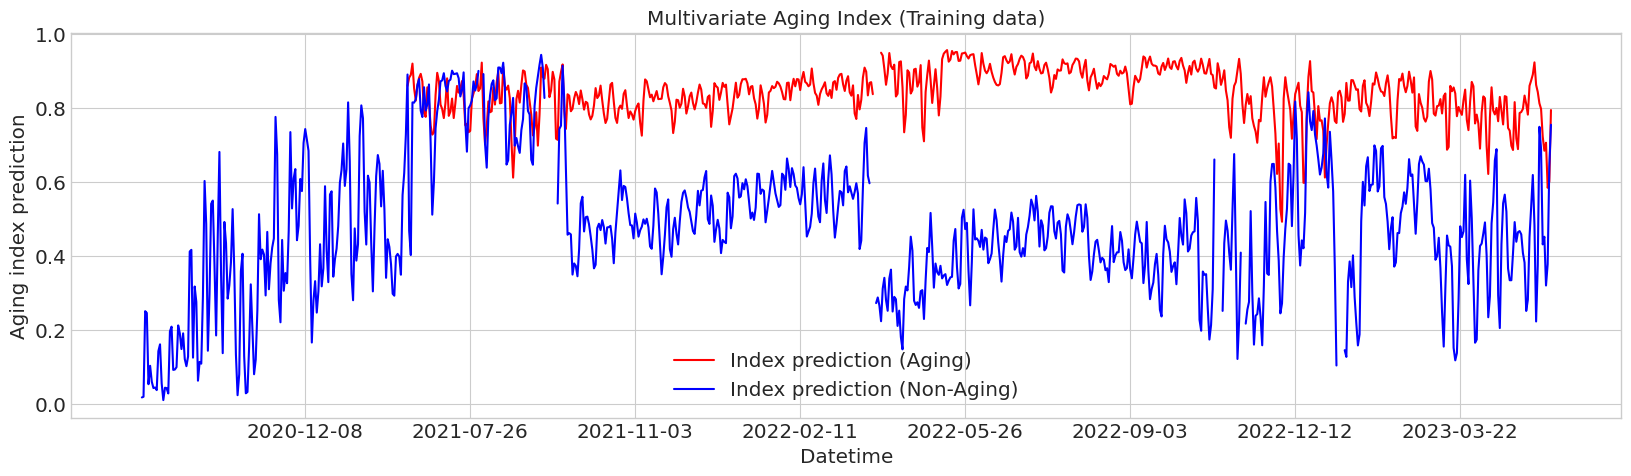

In [30]:
data_pet_matrix_train_test[data_pet_matrix_train_test.columns[data_pet_matrix_train_test.columns.isin(aging_pet_ids)]]\
                .mean(axis=1).rolling(2).mean().plot(label='Index prediction (Aging)',color='red',figsize=(20,5))
data_pet_matrix_train_test[data_pet_matrix_train_test.columns[data_pet_matrix_train_test.columns.isin(non_aging_pet_ids)]]\
                .mean(axis=1).rolling(2).mean().plot(label='Index prediction (Non-Aging)',color='blue')
plt.xlabel('Datetime')
plt.ylabel('Aging index prediction')
plt.title("Multivariate Aging Index (Training data)")
plt.legend()

### Out of sample test performance

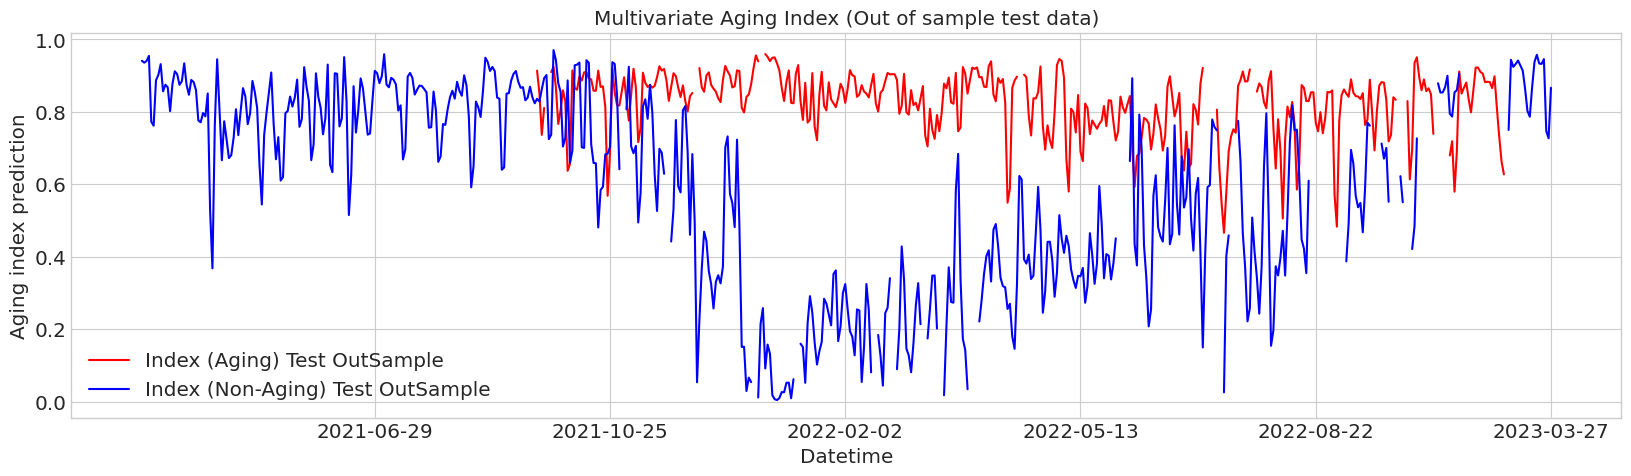

In [82]:
data_pet_matrix_outsample[aging_out_sample].mean(axis=1).rolling(2).mean().plot(figsize=(20,5),\
                                                                                   label='Index (Aging) Test OutSample',\
                                                                                   color='r')
data_pet_matrix_outsample[non_aging_out_sample].mean(axis=1).rolling(2).mean().plot(figsize=(20,5),\
                                                                                  label='Index (Non-Aging) Test OutSample',\
                                                                                  color='b')
plt.xlabel('Datetime')
plt.ylabel('Aging index prediction')
plt.title("Multivariate Aging Index (Out of sample test data)")
plt.legend()